# Practice Session 09: Forecasting



<font size="+2" color="blue">Additional results: cross correlations</font>

Author: <font color="blue">Alan Le Roux Osorio</font>

E-mail: <font color="blue"> alan.leroux01@estudiant.upf.edu</font>

Date: <font color="blue">01/12/2025</font>

In [3]:
import io
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# 1. Dataset

In [4]:
# LEAVE AS-IS

INPUT_FILE = "aemet-barcelona-airport-2016-2025.json"
weather = pd.read_json(INPUT_FILE)

display(weather.head(5))
display(weather.tail(5))

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
3334,2025-08-19,0076,BARCELONA AEROPUERTO,BARCELONA,4,"27,8","0,7","25,5",Varias,"30,0",...,"4,1","1014,8",Varias,"1009,5",Varias,71.0,82.0,Varias,42.0,08:24
3335,2025-08-20,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,2","32,9","19,8",22:43,"28,5",...,"5,0","1011,2",Varias,"1007,9",17,62.0,94.0,Varias,54.0,11:28
3336,2025-08-21,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,4","0,0","19,5",05:11,"29,2",...,"9,0","1014,2",Varias,"1009,2",04,58.0,92.0,00:19,41.0,14:04
3337,2025-08-22,0076,BARCELONA AEROPUERTO,BARCELONA,4,"24,9","0,0","21,3",04:25,"28,5",...,"9,7","1016,0",Varias,"1013,4",04,65.0,82.0,Varias,48.0,09:42
3338,2025-08-23,0076,BARCELONA AEROPUERTO,BARCELONA,4,"25,1","0,0","21,3",05:42,"28,9",...,"11,9","1016,1",Varias,"1013,0",18,71.0,86.0,Varias,60.0,08:48


In [5]:
# LEAVE AS-IS

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "temp_min_time",
  "horatmax" : "temp_max_time",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "windspeed_gusts_time",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "pressure_max_time",
  "presMin" : "pressure_min",
  "horaPresMin" : "pressure_min_time",
  "hrMedia": "relhumidity_mean",
  "hrMax": "relhumidity_max",
  "hrMin": "relhumidity_min",
  "horaHrMax": "relhumidity_max_time", 
  "horaHrMin": "relhumidity_min_time"
}

In [6]:
# we iterate through the dictionary and rename the columns in the DataFrame
for old_name, new_name in COLUMN_NAMES.items():
    if old_name in weather.columns:
        weather.rename(columns={old_name: new_name}, inplace=True)
    

In [7]:

#The statement gives us the columns that need to be dropped from the DataFrame.
#We first define a list of column names that we want to drop, and then use the `drop` method of the DataFrame to remove those columns.
drop_columns = [
    "station_num",
    "station_name",
    "station_province",
    "station_altitude",
    "temp_min_time", 
    "temp_max_time", 
    "pressure_min_time", 
    "pressure_max_time",
]
for col in drop_columns:
        weather.drop(columns=col, inplace=True, errors='ignore')
display(weather.head(10))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,"23,8","0,0","21,8","25,9",25.0,"3,3","6,7",23:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,"25,3","0,0","23,2","27,4",35.0,"3,1","6,4",02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-07-06,"25,8","0,0","23,1","28,5",20.0,"5,0","11,7",16:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-07-07,"25,4","0,0","23,7","27,1",99.0,"3,9","10,3",14:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2016-07-08,"26,2","0,1","24,0","28,4",23.0,"2,5","10,6",04:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2016-07-09,"26,6","0,0","24,8","28,5",18.0,"3,1","6,7",12:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2016-07-10,"26,8","0,0","24,9","28,6",19.0,"4,7","9,2",11:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# LEAVE THIS CODE AS-IS

display(weather.head(5))
display(weather.tail(5))
weather.shape

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,"23,8","0,0","21,8","25,9",25.0,"3,3","6,7",23:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,"25,3","0,0","23,2","27,4",35.0,"3,1","6,4",02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
3334,2025-08-19,"27,8","0,7","25,5","30,0",34.0,"5,0","12,5",09:38,"4,1","1014,8","1009,5",71.0,82.0,Varias,42.0,08:24
3335,2025-08-20,"24,2","32,9","19,8","28,5",4.0,"4,2","14,4",13:28,"5,0","1011,2","1007,9",62.0,94.0,Varias,54.0,11:28
3336,2025-08-21,"24,4","0,0","19,5","29,2",99.0,"4,7","8,9",Varias,"9,0","1014,2","1009,2",58.0,92.0,00:19,41.0,14:04
3337,2025-08-22,"24,9","0,0","21,3","28,5",35.0,"5,0","10,8",07:15,"9,7","1016,0","1013,4",65.0,82.0,Varias,48.0,09:42
3338,2025-08-23,"25,1","0,0","21,3","28,9",24.0,"5,8","11,4",Varias,"11,9","1016,1","1013,0",71.0,86.0,Varias,60.0,08:48


(3339, 17)

In [9]:


def str_commas_to_float(x):
    # We keep floats and integers unchanged
    if isinstance(x, (int, float)):
        return float(x)

    # HHere we handle "Ip"
    if x == "Ip":
        return 0.0

    # HHere we handle strings
    if isinstance(x, str):
        x = x.strip()

        if x == "":
            return np.nan

        # We replace comma decimal separator
        x = x.replace(",", ".")

        try:
            return float(x)
        except ValueError:
            return np.nan

    # And anything else will be NaN
    return np.nan


In [10]:
# Tests for values that must return NaN
assert np.isnan(str_commas_to_float(""))
assert np.isnan(str_commas_to_float("Varias"))
assert np.isnan(str_commas_to_float("06:30"))

# Tests for values that must return 0.0
assert str_commas_to_float("0,0") == 0.0
assert str_commas_to_float("Ip") == 0.0

# Tests for decimal with comma
assert str_commas_to_float("13,5") == 13.5

# Tests for integer string
assert str_commas_to_float("13") == 13.0


In [11]:
weather["temp_min"] = weather["temp_min"].apply(str_commas_to_float)
weather["temp_max"] = weather["temp_max"].apply(str_commas_to_float)
weather["temp_avg"] = weather["temp_avg"].apply(str_commas_to_float)
weather["rainfall"] = weather["rainfall"].apply(str_commas_to_float)
weather["windspeed_dir"] = weather["windspeed_dir"].apply(str_commas_to_float)
weather["windspeed_avg"] = weather["windspeed_avg"].apply(str_commas_to_float)
weather["windspeed_gusts"] = weather["windspeed_gusts"].apply(str_commas_to_float)
weather["pressure_min"] = weather["pressure_min"].apply(str_commas_to_float)
weather["pressure_max"] = weather["pressure_max"].apply(str_commas_to_float)
weather["relhumidity_min"] = weather["relhumidity_min"].apply(str_commas_to_float)
weather["relhumidity_max"] = weather["relhumidity_max"].apply(str_commas_to_float)

In [12]:
# LEAVE THIS CODE AS-IS

display(weather.head(5))
display(weather.tail(5))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
0,2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,10:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,12:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,08:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,23:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
3334,2025-08-19,27.8,0.7,25.5,30.0,34.0,5.0,12.5,09:38,"4,1",1014.8,1009.5,71.0,82.0,Varias,42.0,08:24
3335,2025-08-20,24.2,32.9,19.8,28.5,4.0,4.2,14.4,13:28,"5,0",1011.2,1007.9,62.0,94.0,Varias,54.0,11:28
3336,2025-08-21,24.4,0.0,19.5,29.2,99.0,4.7,8.9,Varias,"9,0",1014.2,1009.2,58.0,92.0,00:19,41.0,14:04
3337,2025-08-22,24.9,0.0,21.3,28.5,35.0,5.0,10.8,07:15,"9,7",1016.0,1013.4,65.0,82.0,Varias,48.0,09:42
3338,2025-08-23,25.1,0.0,21.3,28.9,24.0,5.8,11.4,Varias,"11,9",1016.1,1013.0,71.0,86.0,Varias,60.0,08:48


In [13]:
# LEAVE AS-IS

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
display(weather.head(3))

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
date,,,,,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,10:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,12:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,08:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# LEAVE THIS CELL AS-IS

# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

# Flexible plotting function

def plot_min_max(df, min_col='', max_col='', avg_col='', avg_label='Average', 
                     title='Weather', xlabel='Date', ylabel='Variable'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    if avg_col:
        plt.plot_date(df.index, df[avg_col],
                      fmt='.-', color='black', label=avg_label)
    if min_col and max_col:
        plt.fill_between(df.index, df[min_col], df[max_col],
                         color='lightgray')
    if avg_col:
        plt.legend()

    # Label axis
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
    
# Simple version


# Plot function
def plot_variable(df, col='', label='', title='Weather', xlabel='Date', ylabel=''):
    
    plot_min_max(df, title=title, xlabel=xlabel, ylabel=ylabel, avg_col=col, avg_label=label)

    plt.show()


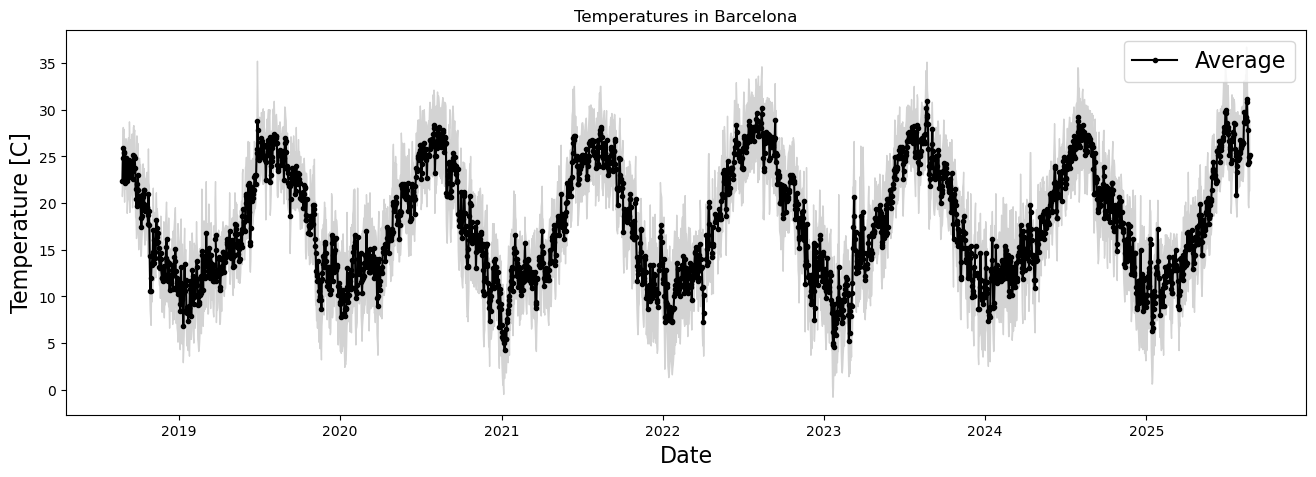

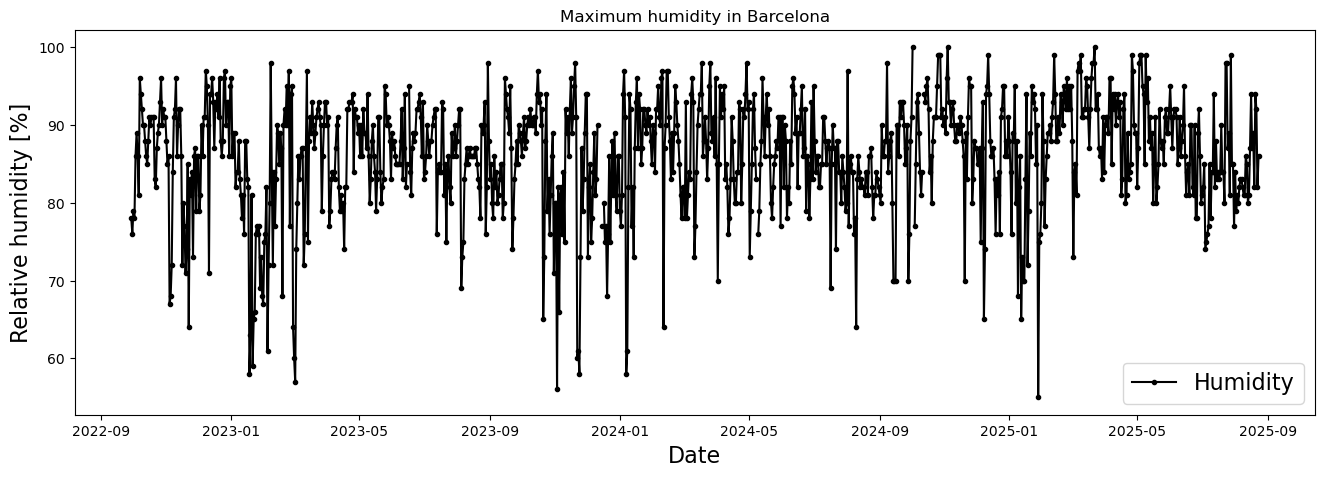

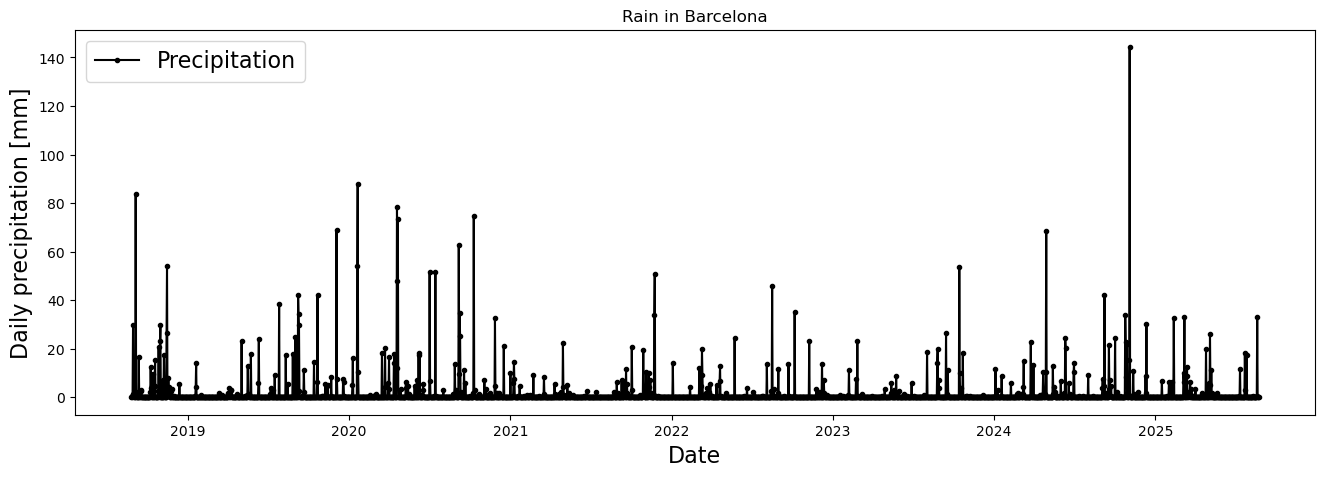

In [15]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather.tail(7*365)

# Plot temperature
plot_min_max(weather_sample, title='Temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Rain in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')


Temperature: You can clearly see a yearly pattern. It goes up in summer and down in winter, almost like a smooth wave. The minimum, maximum, and average temperatures all follow this same shape every year.

Humidity: There also seems to be a yearly pattern, but it’s not as clean as temperature. Humidity is usually lower in the colder months (every first monnth of the year the % of humidity goes down). However, the data looks a bit noisy so the pattern is harder to see.

Precipitation: Here the seasonality is not very strong. There are many days with zero or almost zero rain, and then some random big spikes. There are slightly more rainy events in autumn and winter, but overall the pattern is irregular, which makes it harder to forecast.

## 1.1 Smooth the series using moving averages

In [16]:
def moving_average(df, window_size):

    averages = []
    
    for i in range(len(df)):
        
        # we determine the  window boundaries
        start = max(0, i - window_size + 1)
        end = i + 1

        # and extract window of rows
        window = df.iloc[start:end]
        
        # we compute the  mean of all numeric columns
        average = round(window.mean(numeric_only=True),2)
        
        # And store result
        averages.append(average)

    # Finally we create a dataframe for the smoothed data
    smoothed = pd.DataFrame(averages, columns=df.columns)
    smoothed.set_index(df.index, inplace=True)
    
    return smoothed


In [17]:
# LEAVE AS-IS

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time
date,,,,,,,,,,,,,,,,
2016-07-01,24.10,0.00,21.90,26.30,99.00,3.10,5.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,24.35,0.00,22.10,26.65,56.00,3.35,6.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-03,24.03,0.00,22.03,26.07,44.00,3.63,7.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-04,23.98,0.00,21.98,26.02,39.25,3.55,7.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-05,24.24,0.00,22.22,26.30,38.40,3.46,7.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-06,24.50,0.00,22.37,26.67,35.33,3.72,7.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-07,24.63,0.00,22.56,26.73,44.43,3.74,8.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-08,24.93,0.01,22.86,27.03,33.57,3.66,8.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-09,25.21,0.01,23.21,27.24,34.29,3.59,8.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


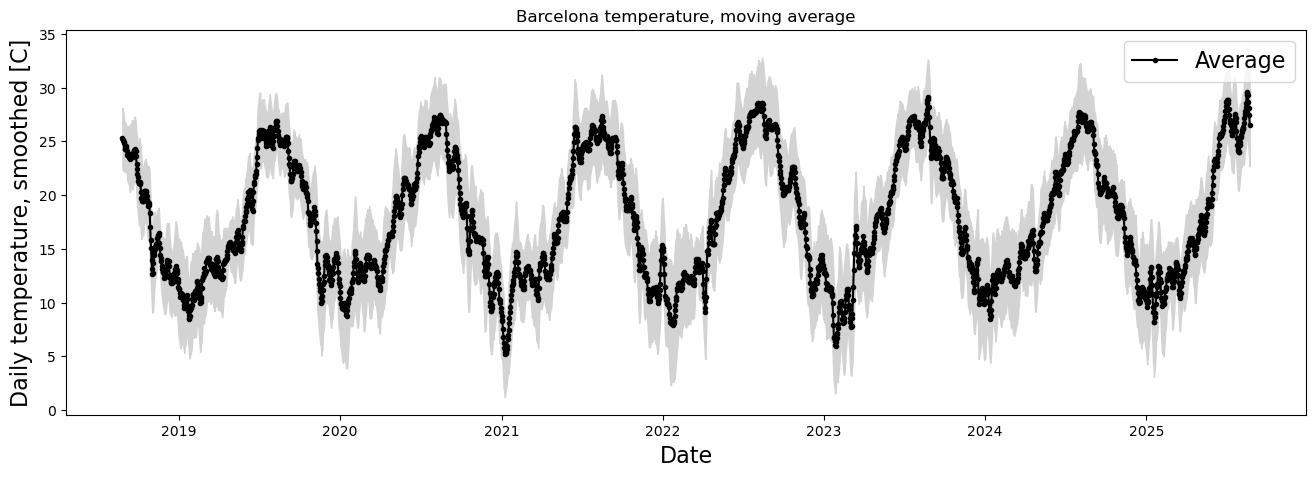

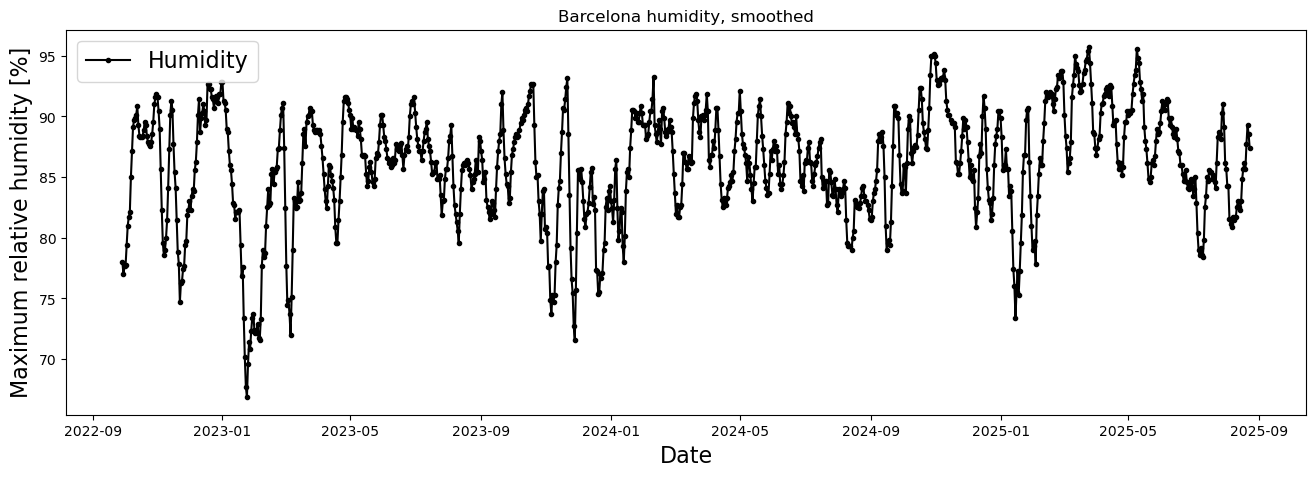

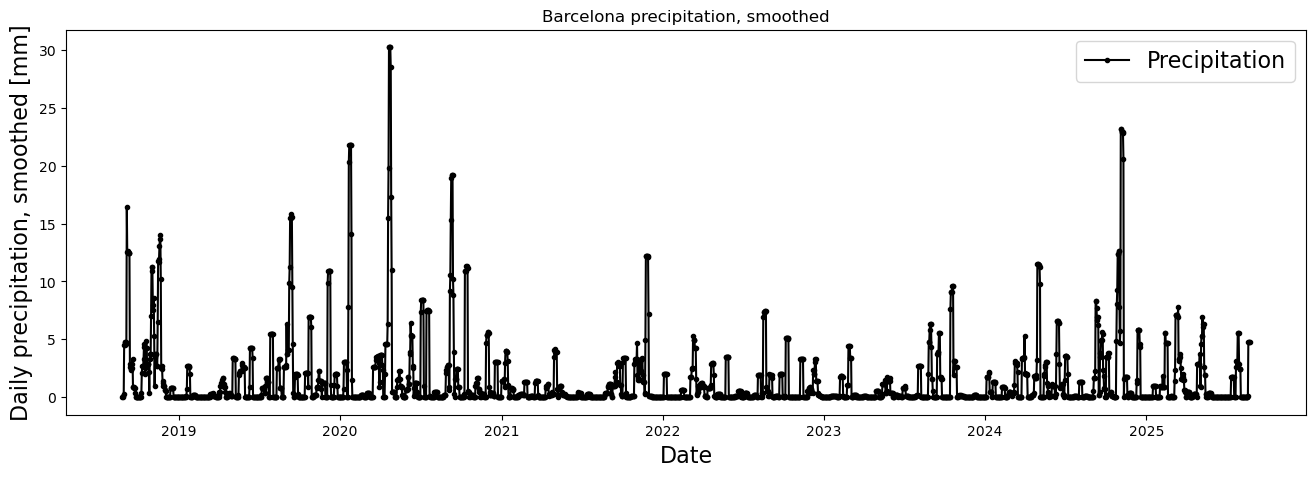

In [18]:
# LEAVE AS-IS

# Sample last 7 years
weather_smoothed_sample = weather_smoothed.tail(7*365)

# Plot smoothed temperature
plot_min_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]',
             title="Barcelona temperature, moving average", 
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot smoothed humidity
plot_variable(weather_smoothed_sample,
              title="Barcelona humidity, smoothed", 
                col="relhumidity_max", label="Humidity", ylabel="Maximum relative humidity [%]")

# Plot smoothed precipitation
plot_variable(weather_smoothed_sample,
              title="Barcelona precipitation, smoothed", 
                col="rainfall", label="Precipitation", ylabel="Daily precipitation, smoothed [mm]")

The hardest parts are dealing with the window at the start, where there aren’t enough previous rows, and correctly selecting the right rows for each step. It’s also a bit tricky to make sure the averages are computed for all numeric columns and that the output keeps the same shape and index as the original datafram

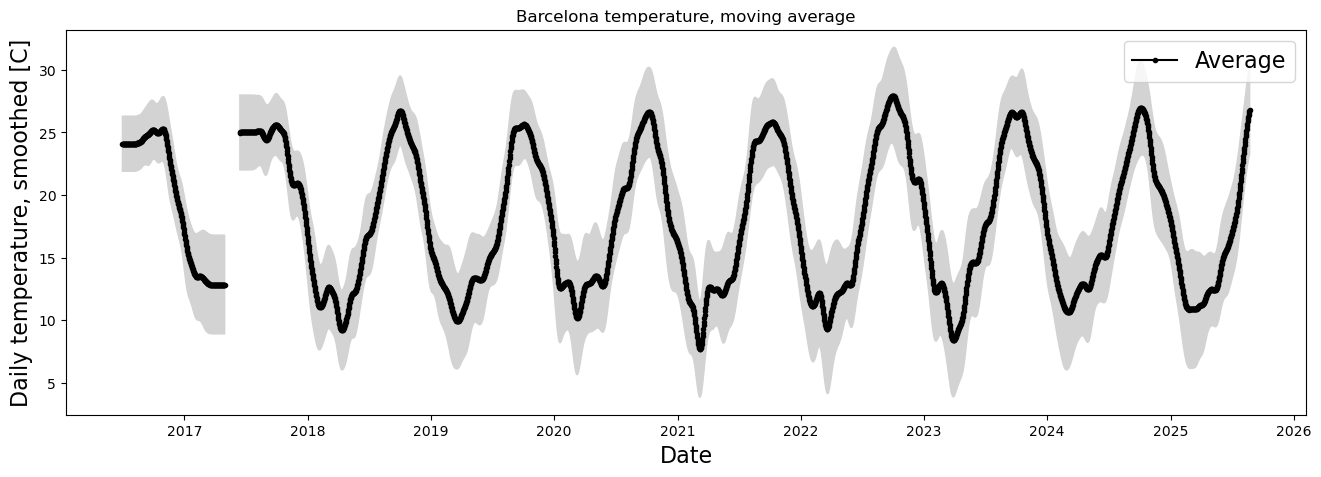

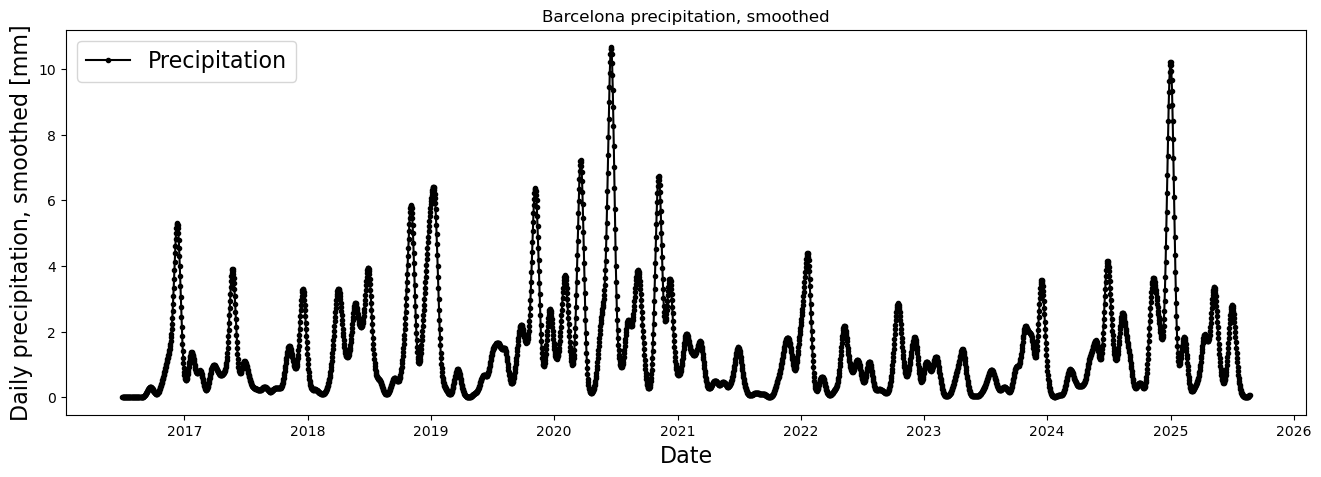

In [19]:
# We reate a separate test dataset to not  modify the original
test = weather.copy()

# We call the function defined previously to smooth the test dataset 20 times
for _ in range(20):
    test = moving_average(test, window_size=7)

# We plot smoothed temperature
plot_min_max(test, ylabel='Daily temperature, smoothed [C]',
             title="Barcelona temperature, moving average", 
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')



# We plot smoothed precipitation
plot_variable(test,
              title="Barcelona precipitation, smoothed", 
                col="rainfall", label="Precipitation", ylabel="Daily precipitation, smoothed [mm]")





In the repeatedly smoothed dataset plots for precipitation and temperature, it is easier to observe seasonality. This happens because smoothing reduces  random noise, showing more clearly the underlying yearly patterns. Peaks and troughs stand out more, making it simpler to identify seasonality in temperature and precipitation.


## 1.2. Smooth the series by binning per floating weeks

In [20]:


def list_of_floating_week_starts(first, last):
    weeks = []
    
    current = first
    
    # Keep adding weekly steps until we pass "last"
    while current <= last:
        weeks.append(current)
        current = current + datetime.timedelta(weeks=1)
    
    # Add one more element (the week after last)
    weeks.append(current)
    
    return weeks


In [21]:
# LEAVE AS-IS

# Remember that our data frame is indexedb by date
first_day = np.min(weather.index)
last_day = np.max(weather.index)

# Obtain the list of weeks
weeks = list_of_floating_week_starts(first_day, last_day)

# Print the list of weeks
print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" %
      (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 479 week starts
First week starts 2016-07-01, last week starts 2025-08-29


In [22]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather.copy()
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time,week_start
date,,,,,,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,10:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,12:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,08:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,23:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-06,25.8,0.0,23.1,28.5,20.0,5.0,11.7,16:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-07,25.4,0.0,23.7,27.1,99.0,3.9,10.3,14:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-08,26.2,0.1,24.0,28.4,23.0,2.5,10.6,04:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-08
2016-07-09,26.6,0.0,24.8,28.5,18.0,3.1,6.7,12:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-08


In [23]:
# Aggregate by floating week
weather_per_floating_week = weather_with_week_start.groupby('week_start').aggregate({
    "temp_min": np.mean,
    "temp_avg": np.mean,
    "temp_max": np.mean,
    "rainfall": np.sum,
    "relhumidity_max": np.mean, # Thanks to a question in the forum we add this column as in the next cell we have to plot this value
})

weather_per_floating_week.tail() #THe head would show nan values in the relhumidity_max column because the first entries are incomplete


,temp_min,temp_avg,temp_max,rainfall,relhumidity_max
week_start,,,,,
2025-07-25,20.957143,24.642857,28.314286,17.3,86.142857
2025-08-01,23.000000,26.185714,29.357143,0.0,81.714286
2025-08-08,24.400000,28.214286,32.000000,0.3,82.285714
2025-08-15,23.828571,28.057143,32.228571,33.7,89.285714
2025-08-22,21.300000,25.000000,28.700000,0.0,84.000000


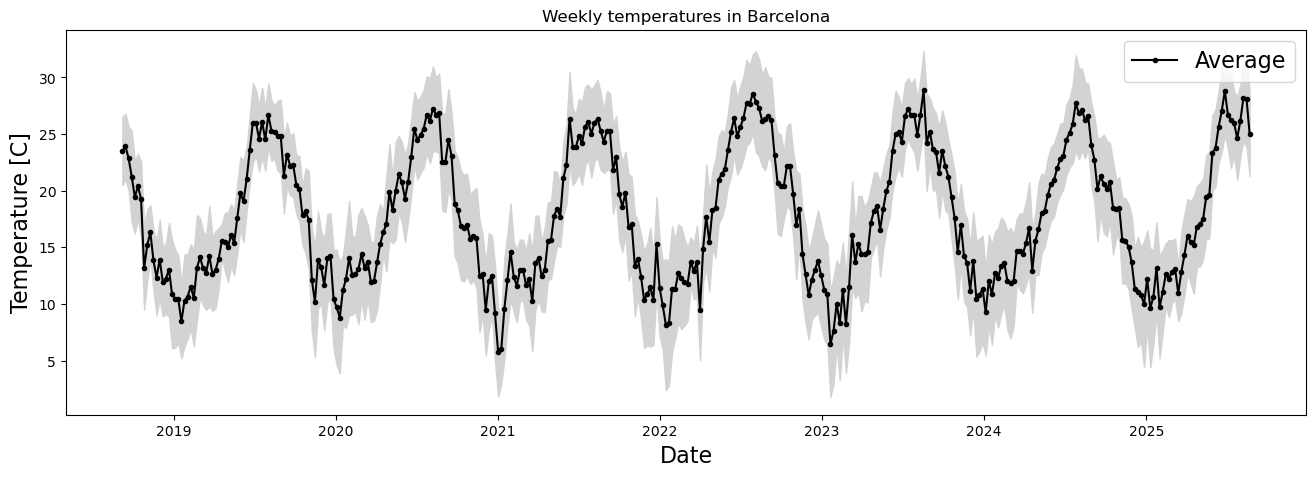

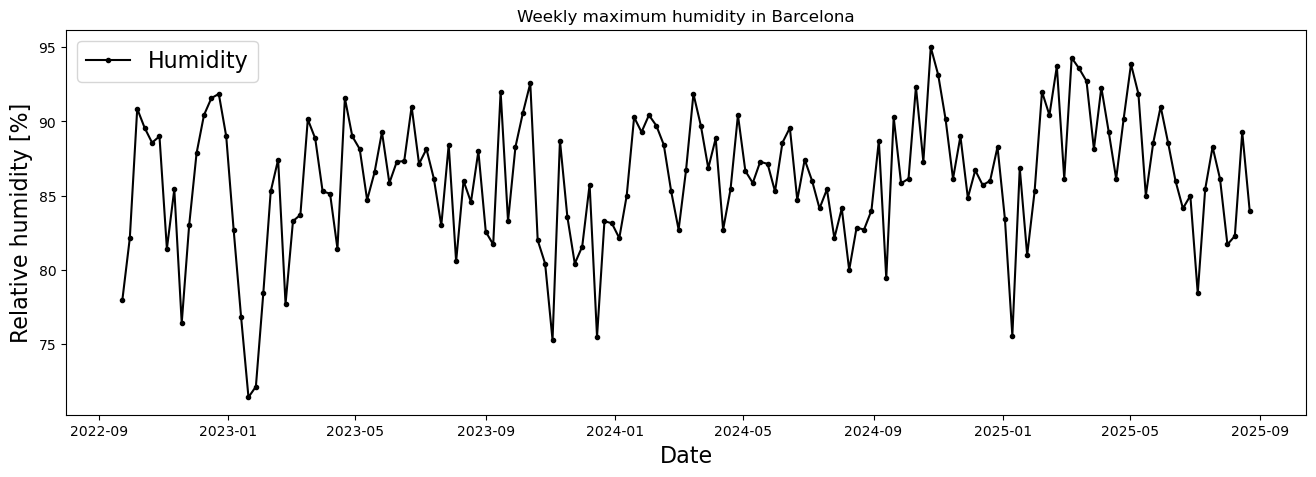

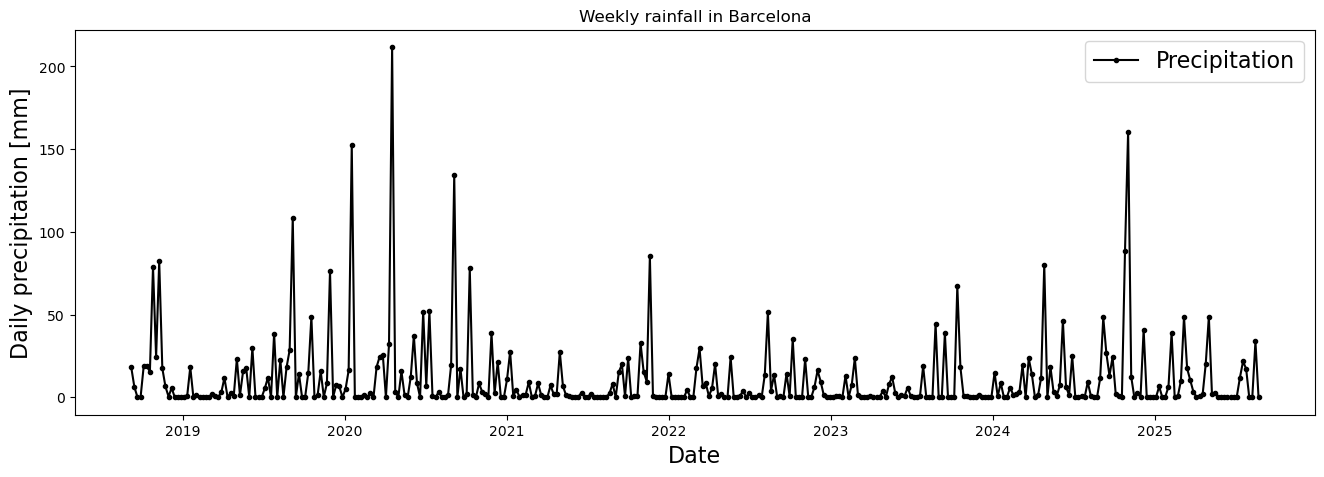

In [24]:
# LEAVE AS-IS

# Retrieve the past 5 years
weather_sample = weather_per_floating_week.tail(7*52)

# Plot temperature
plot_min_max(weather_sample, title='Weekly temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Weekly maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Weekly rainfall in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')

Temperature: clear yearly seasonality — smooth  pattern with higher values in summer and lower in winter. Weekly aggregation makes the seasonal cycle more visible and reduces noise.

Humidity: some seasonal signal exists but the series is noisier and many missing values.

Precipitation: very irregular — many days with zero rain and occasional large spikes. Seasonality is weak (slightly more rain in autumn/winter). Weekly binning reduces daily noise but large spikes still dominate.

## 1.3. Smooth the series by binning per month

In [25]:

def list_of_month_starts(first, last):
    # We start from the first day of the first observation's month
    current = first.replace(day=1)
    months = [current]
    
    # KWe keep adding months until passing the last observation
    while current <= last:
        if current.month < 12:
            current = current.replace(month=current.month + 1)
        else:  
            current = current.replace(year=current.year + 1, month=1)
        months.append(current)
    
    return months


In [26]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 111 month starts
First month starts 2016-07-01, last month starts 2025-09-01


In [27]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,windspeed_gusts_time,sun,pressure_max,pressure_min,relhumidity_mean,relhumidity_max,relhumidity_max_time,relhumidity_min,relhumidity_min_time,month_start
date,,,,,,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,10:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,12:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,08:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,23:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-19,27.8,0.7,25.5,30.0,34.0,5.0,12.5,09:38,"4,1",1014.8,1009.5,71.0,82.0,Varias,42.0,08:24,2025-08-01
2025-08-20,24.2,32.9,19.8,28.5,4.0,4.2,14.4,13:28,"5,0",1011.2,1007.9,62.0,94.0,Varias,54.0,11:28,2025-08-01
2025-08-21,24.4,0.0,19.5,29.2,99.0,4.7,8.9,Varias,"9,0",1014.2,1009.2,58.0,92.0,00:19,41.0,14:04,2025-08-01


In [28]:
# We Aggregate by floating week
weather_per_month = weather_with_month_start.groupby('month_start').aggregate({
    "temp_min": np.mean,
    "temp_avg": np.mean,
    "temp_max": np.mean,
    "rainfall": np.sum,
    "relhumidity_max": np.mean, 
})

weather_per_month.tail() #THe head would show nan values in the relhumidity_max column because the first entries are incomplete


,temp_min,temp_avg,temp_max,rainfall,relhumidity_max
month_start,,,,,
2025-04-01,12.046667,15.610000,19.176667,26.0,89.833333
2025-05-01,14.980645,18.712903,22.432258,53.5,89.612903
2025-06-01,22.160000,25.580000,29.003333,0.0,87.133333
2025-07-01,22.703226,26.164516,29.629032,51.1,84.387097
2025-08-01,23.530435,27.269565,30.978261,34.0,84.391304


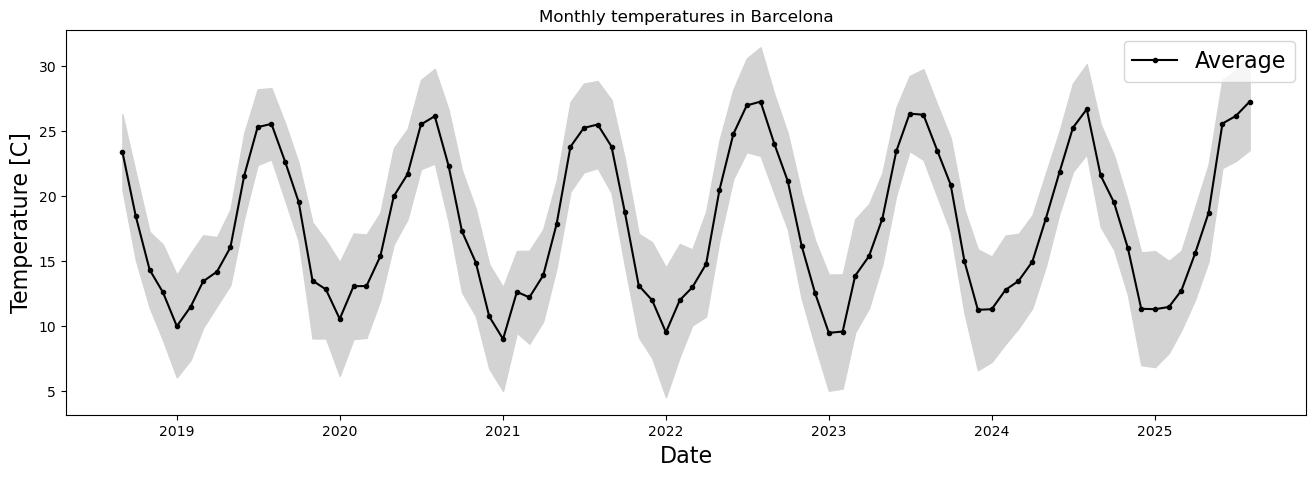

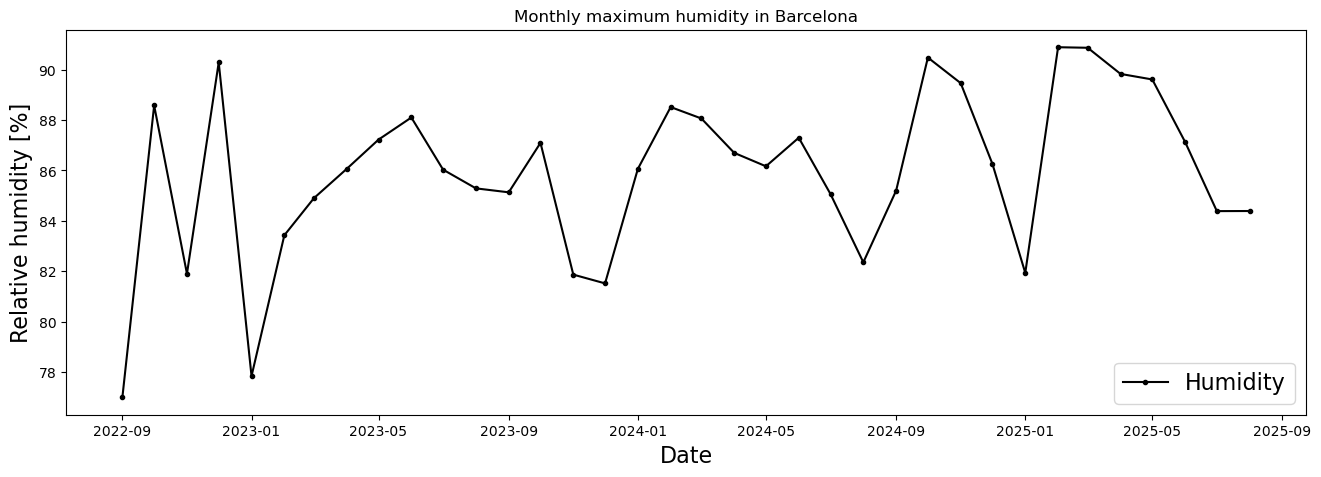

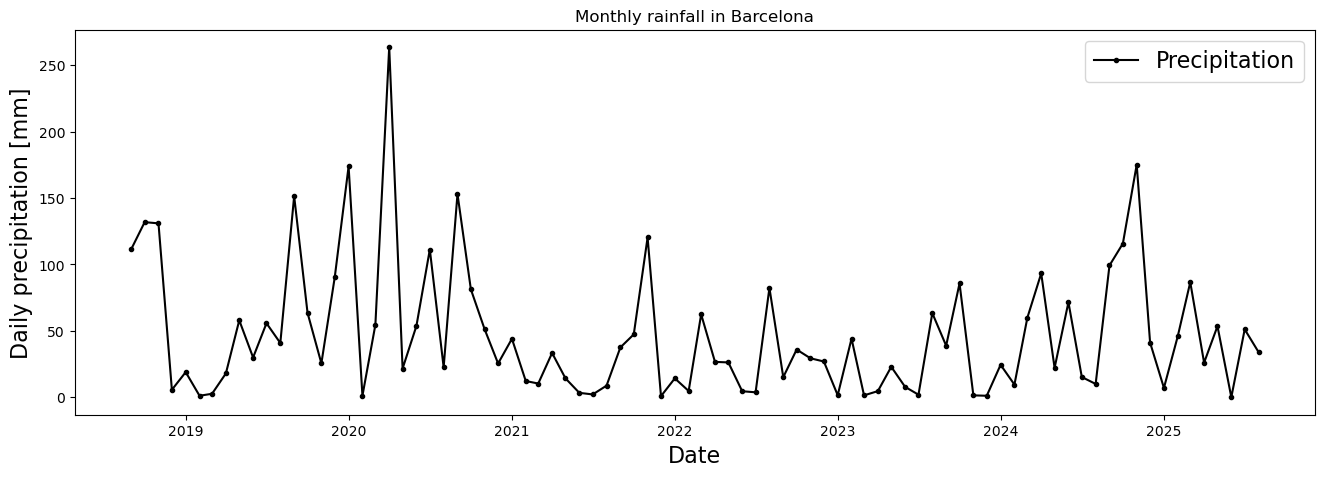

In [29]:
# LEAVE AS-IS

# Retrieve the last 7 years
weather_sample = weather_per_month.tail(7*12)

# Plot temperature
plot_min_max(weather_sample, title='Monthly temperatures in Barcelona', ylabel='Temperature [C]',
             min_col='temp_min', max_col='temp_max', avg_col='temp_avg')

# Plot humidity
plot_variable(weather_sample, title='Monthly maximum humidity in Barcelona', ylabel='Relative humidity [%]',
             col='relhumidity_max', label='Humidity')

# Plot precipitation
plot_variable(weather_sample, title='Monthly rainfall in Barcelona', ylabel='Daily precipitation [mm]', 
            col='rainfall', label='Precipitation')

Temperature : It is a strong and clear yearly seasonality. Monthly  makes the annual cycle very smooth ,highs in summer and lows in winter are obvious and consistent across years.

Humidity: A weaker seasonal signal than temperature. There is some yearly pattern (higher in cooler months), but the series is noisier and many early months have missing values, so the signal is less reliable.

Precipitation : It is very irregular. Monthly maybe reduces day-to-day noise but sporadic  precipitation events still dominate; any seasonality is much weaker than for temperature a.

Overall the temperature is the most predictable (clean seasonal pattern). Humidity shows moderate predictability but is noisier and affected by missing data and precipitation is the least predictable.



# 2. Perform forecasting

## 2.1. Compute auto-correlation plots

In [30]:
#We define a function that, given a series and a lag value, returns two lists: 
# the original series trimmed to exclude the initial values that do not have corresponding lagged values,
# and the lagged series itself.
def lagged_series(series, lag):
    original_trimmed = []
    lagged = []
    
    for i in range(len(series)):
        j = i - lag
        if j >= 0 and not np.isnan(series[i]) and not np.isnan(series[j]):
            original_trimmed.append(series[i])
            lagged.append(series[j])
    
    return original_trimmed, lagged



In [31]:
# LEAVE AS-IS

assert ([44, 55, 66, 77, 88], [11, 22, 33, 44, 55]) == lagged_series([11,22,33,44,55,66,77,88], 3)

assert ([33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66]) == lagged_series([11,22,33,44,55,66,77,88], 2)

assert ([22, 33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66, 77]) == lagged_series([11,22,33,44,55,66,77,88], 1)


In [32]:
# LEAVE AS-IS

# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

In [33]:
#We define a function that computes autocorrelations for lags from 0 up to max_periods - 1

def compute_autocorrelations(series, max_periods):
    #Empty list to store autocorrelations
    autocorrs = []
    # Iterate over lag values   
    for lag in range(max_periods):
        #We call the function previously defined to get the lagged series
        orig, lagged = lagged_series(series, lag)
        # And compute correlation
        corr = np.corrcoef(orig, lagged)[0, 1]
        #we append the correlation to the list
        autocorrs.append(corr)
    return np.array(autocorrs)

# Set the maximum number of periods (2 years of daily data)
max_periods = 2 * 365

# Compute autocorrelations
auto_correlations_temp_avg = compute_autocorrelations(weather['temp_avg'].values, max_periods)
auto_correlations_temp_max = compute_autocorrelations(weather['temp_max'].values, max_periods)
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'].values, max_periods)
auto_correlations_relhumidity = compute_autocorrelations(weather['relhumidity_max'].values, max_periods)


In [34]:
# LEAVE AS-IS

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

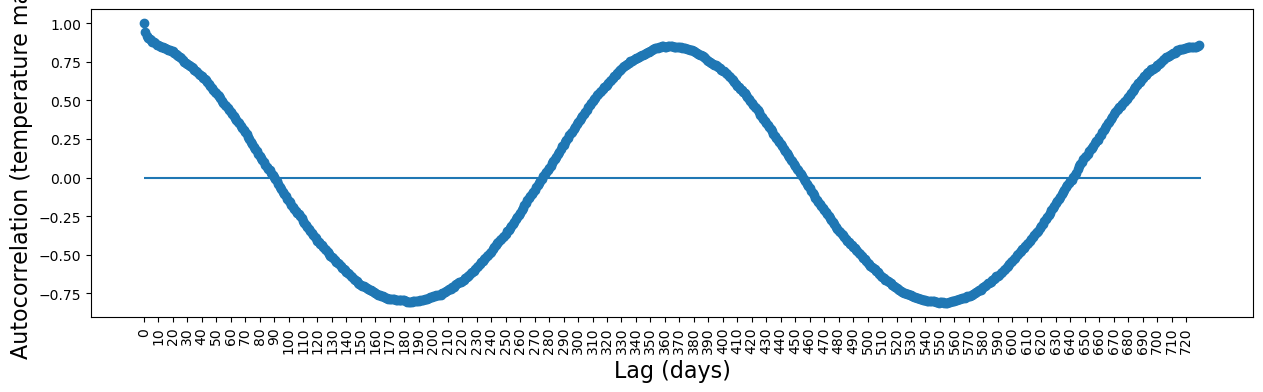

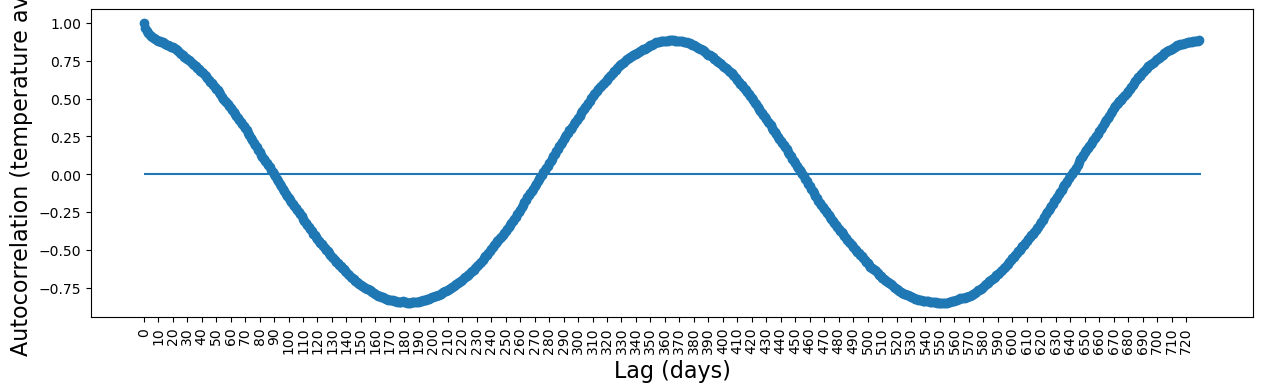

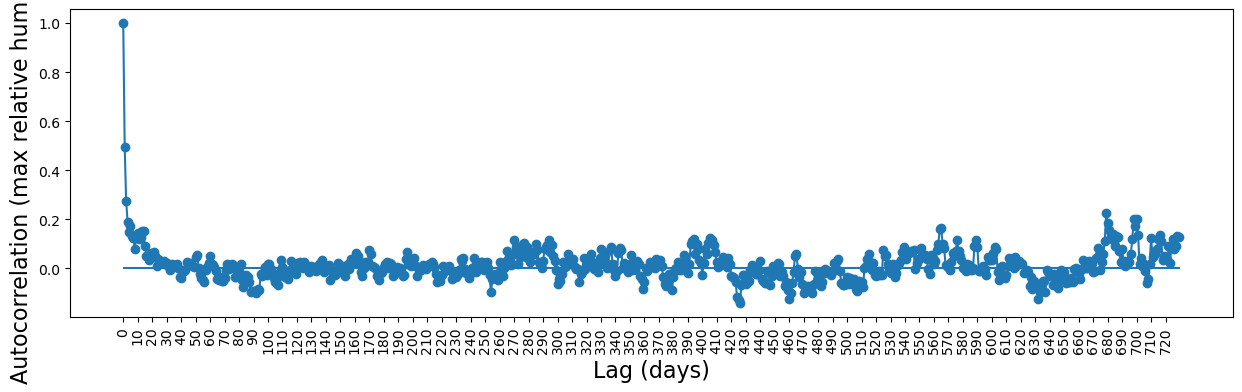

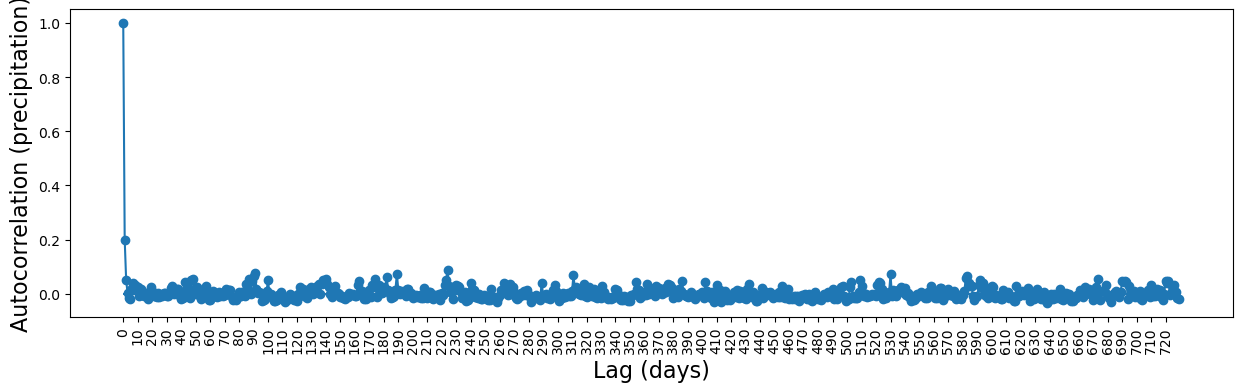

In [35]:
# LEAVE AS-IS

# Plot max temperature auto-correlation
plot_auto_correlations(auto_correlations_temp_max, ylabel="Autocorrelation (temperature max)")

# Plot avg temperature auto-correlation
plot_auto_correlations(auto_correlations_temp_avg, ylabel="Autocorrelation (temperature avg)")

# Plot max relative humidity auto-correlation
plot_auto_correlations(auto_correlations_relhumidity, ylabel="Autocorrelation (max relative humidity)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

Temperature :The autocorrelation is strong and decreases slowly. There are clear repeating peaks every year (around 365 days, and again around 730 days). This means temperature from one day to the next is very similar, and the yearly seasons create a predictable pattern. So, temperature is highly predictable, especially at seasonal time scales.

Humidity : There is some seasonal pattern (yearly peaks), but it is weaker and noisier than temperature. The autocorrelation drops faster, meaning humidity changes more from day to day. It still has some structure, but not as strong. So humidity is moderately predictable, but less than temperature.

Precipitation : The autocorrelation is very low for almost all lags (except lag 0 and sometimes lag 1). Rainfall is made up of sudden spikes and long periods with no rain, so it does not show regular patterns. Any peaks that appear are usually caused by a few specific events, not a real pattern. So precipitation is mostly unpredictable.

Most unpredictable : Precipitation is the least predictable of the three. Humidity still shows some seasonal behavior, but precipitation looks almost random.

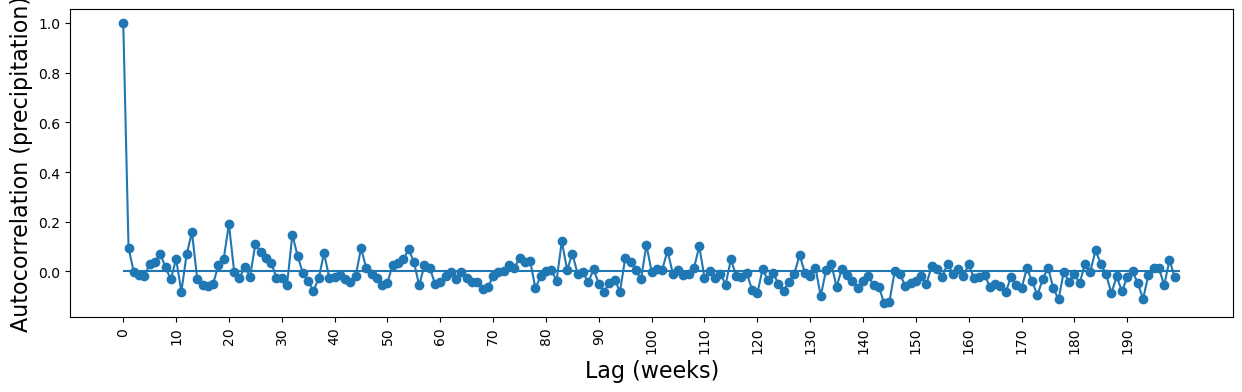

In [36]:
# LEAVE AS-IS

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

The weekly precipitation autocorrelation has one clear spike at lag 1, but after that all the values are very small and look like random noise. The spike at lag 1 makes sense because rainy weeks sometimes happen close together.

However, the other tiny peaks are probably not real patterns. Rainfall is very irregular, with lots of weeks having zero rain and a few weeks with very heavy storms. When we group the data by week, these rare big storms can create “fake” correlations at certain lags.

So overall, except for the small persistence at lag 1, there is no real repeating pattern in weekly precipitation. Most of the correlations we see are likely due to chance rather than a true physical cycle.

## 2.2. Prepare a system of equations to learn an auto-regressive model

In [37]:
#We define a function that, given a series and a list of lag values, prepares the matrices X and y for regression.



def prepare_matrices(series, lags):
    y = []
    X = []
    
    # We first check that all lags are valid
    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
    
    # Then we loop over the series starting from max(lags)
    for i in range(np.max(lags), len(series)):
        row = [series[i - lag] for lag in lags]
        target = series[i]
        
        # We skip if any value in row or target is NaN
        if any(np.isnan(row)) or np.isnan(target):
            continue
        
        X.append(row)
        y.append(target)
        
    return np.array(X), np.array(y)



In [38]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 15, 32, 37, 52, 54, 70, 89], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[15 11]
 [32 15]
 [37 32]
 [52 37]
 [54 52]]
y=[37 52 54 70 89]


In [39]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 15, 32, np.nan, 52, 54, 70, 89], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32 15]
 [54 52]]
y=[52 89]


## 2.3. Perform forecasts

In [40]:
# LEAVE AS-IS

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='green', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

In [41]:

#I use this lag values for monthly temperature forecasting, the last one being the value from one year before
lags_monthly_temperature = [1, 2, 3, 12]


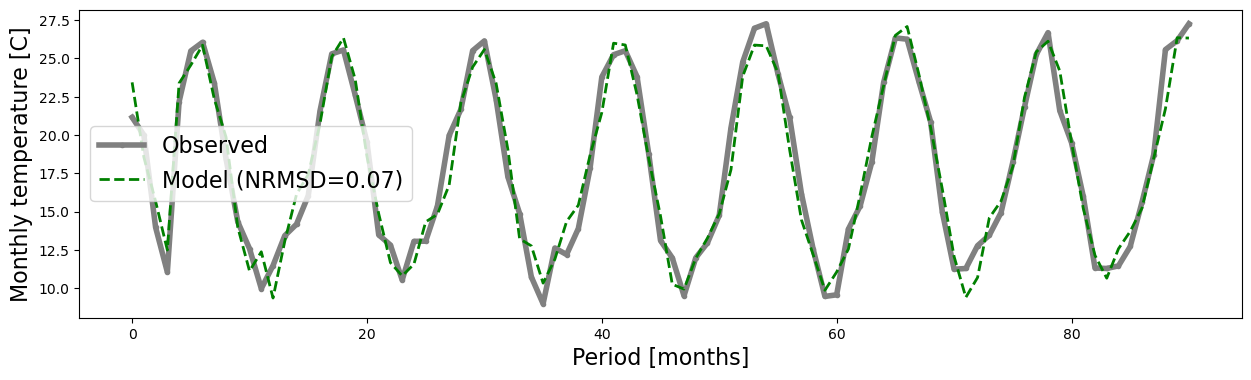

In [42]:
# LEAVE AS-IS

(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'],
                                      lags_monthly_temperature)

plot_forecast(y, y_pred,
              xlabel="Period [months]",
              ylabel="Monthly temperature [C]",
              nrmsd=nrmsd)

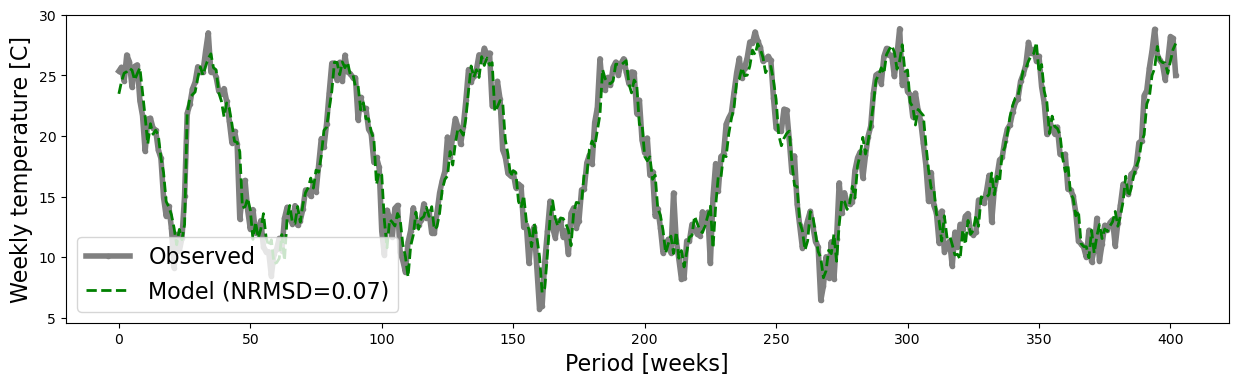

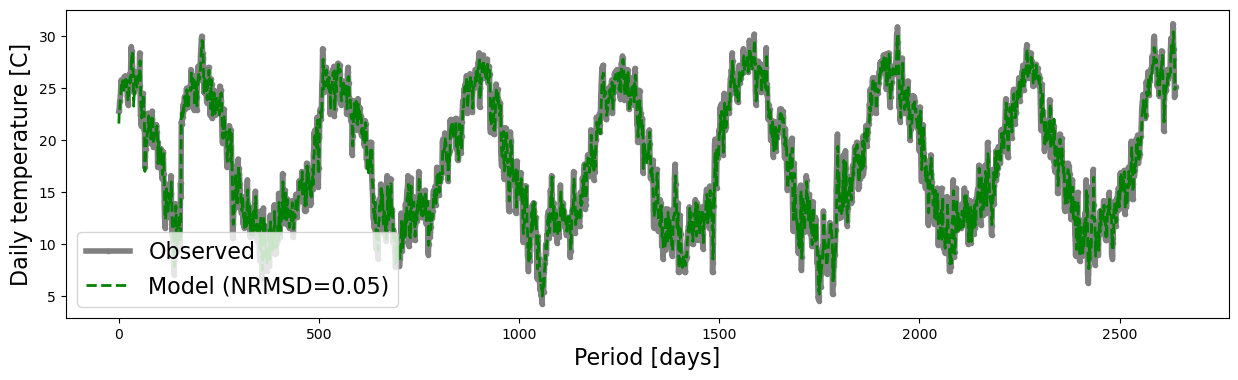

In [43]:
#To this exercise we call the functions previously defined to perform forecasting of weekly and daily temperature.
#We first start with weekly temperature predicting
#We always use lags 1,2,3,4 and 52 (the last one to capture yearly seasonality)
predicted_week_temp = perform_forecast(weather_per_floating_week['temp_avg'],
                                      [1,2,3,4,52])
plot_forecast(predicted_week_temp[0], predicted_week_temp[1],
              xlabel="Period [weeks]",
              ylabel="Weekly temperature [C]",
              nrmsd=predicted_week_temp[2])
#Now we do the same for daily temperature
#We use lags 1,2,3,4 and 365 (the last one to capture yearly seasonality)
predicted_day_temp = perform_forecast(weather['temp_avg'],
                                      [1,2,3,4,365])
plot_forecast(predicted_day_temp[0], predicted_day_temp[1],
              xlabel="Period [days]",
                ylabel="Daily temperature [C]",
                nrmsd=predicted_day_temp[2])





Temperature is very predictable because it has a strong yearly pattern and also changes slowly from one day to the next. This means autoregressive models work quite well.

If we use a few recent lags (like the last 1–4 days/weeks/months) and a seasonal lag (one year earlier), the model can track the seasonal cycle and match the real temperature closely.

The prediction errors (NRMSD) were:

Monthly:0.07

Weekly: 0.07

Daily: 0.05 (best performance)

The biggest mistakes happen during sudden changes or extreme temperatures. When we smooth the data, the seasonal pattern becomes clearer and the predictions become more stable.

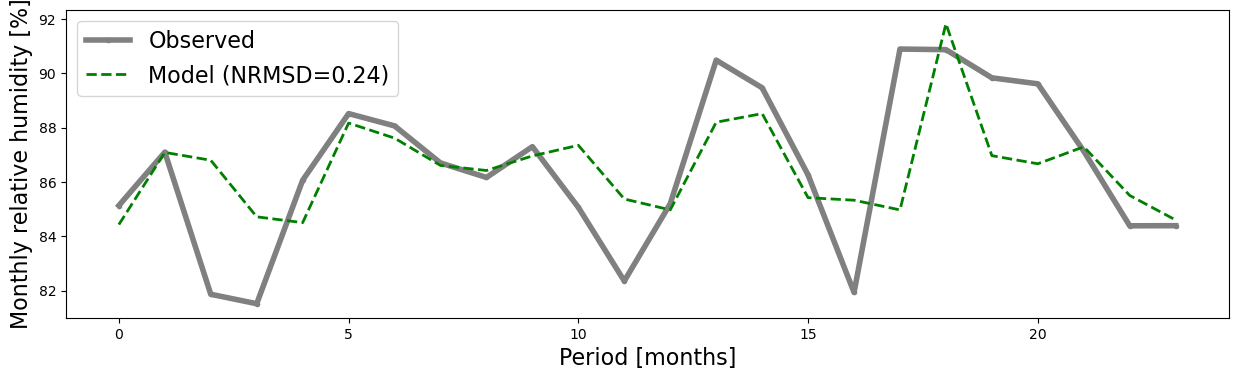

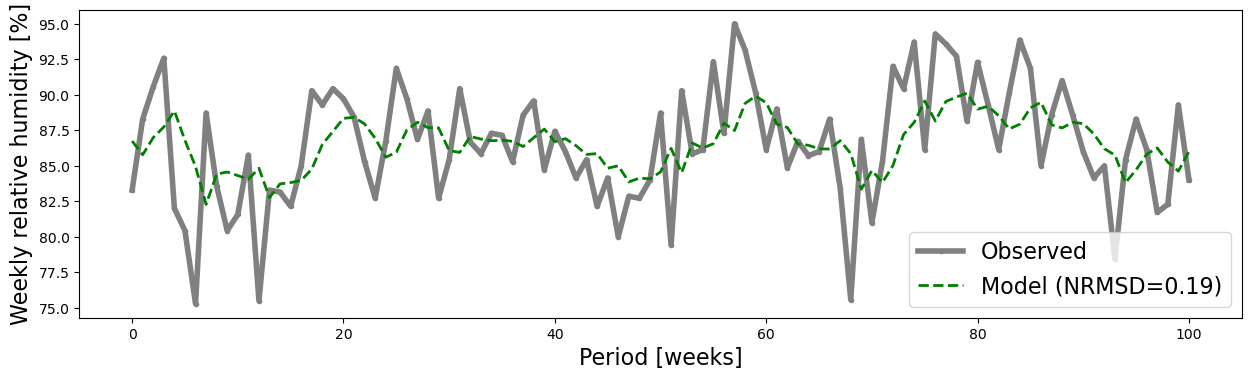

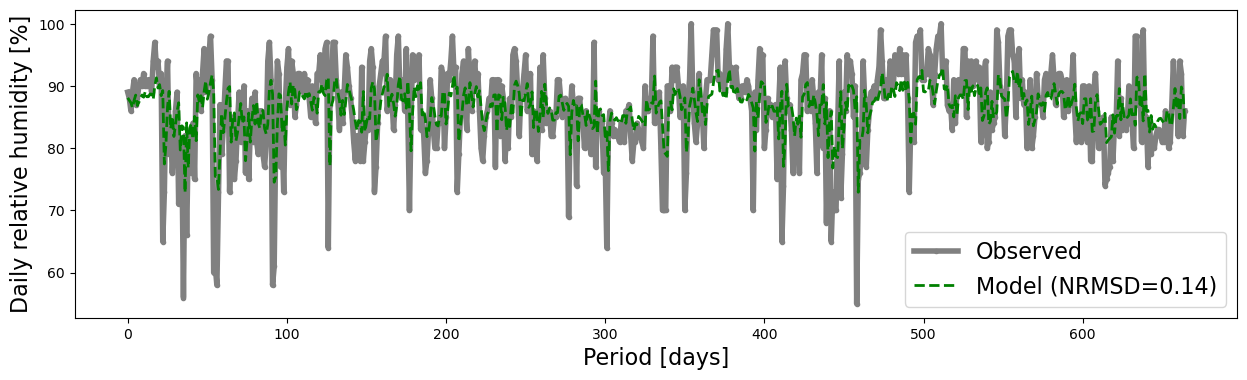

In [44]:
#predicting  monthly relative humidity 
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['relhumidity_max'],
                                      lags_monthly_temperature)
plot_forecast(y, y_pred,
              xlabel="Period [months]",
              ylabel="Monthly relative humidity [%]",
              nrmsd=nrmsd)
#predicting weekly relative humidity
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['relhumidity_max'],
                                      [1,2,3,4,52])
plot_forecast(y, y_pred,
              xlabel="Period [weeks]",  
                ylabel="Weekly relative humidity [%]",
                nrmsd=nrmsd)
#predicting daily relative humidity
(y, y_pred, nrmsd) = perform_forecast(weather['relhumidity_max'],
                                      [1,2,3,4,365])
plot_forecast(y, y_pred,
              xlabel="Period [days]",   
                ylabel="Daily relative humidity [%]",
                nrmsd=nrmsd)


Temperature is easier to predict because it has a clear yearly pattern and changes slowly from day to day, which  makes simple models work well. Relative humidity, on the other hand, is much noisier, often has missing data, and depends on short, sudden weather events like rain, so  seasonal patterns are weaker. As a result, humidity forecasts have larger errors and are less stable, even when smoothing or using weekly/monthly averages. 

<font size="+1" color="red">Extra point</font>

C:\Users\lerou\AppData\Local\Temp\ipykernel_35436\3713057094.py:47: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, cross_corrs[col], basefmt=" ", use_line_collection=True)


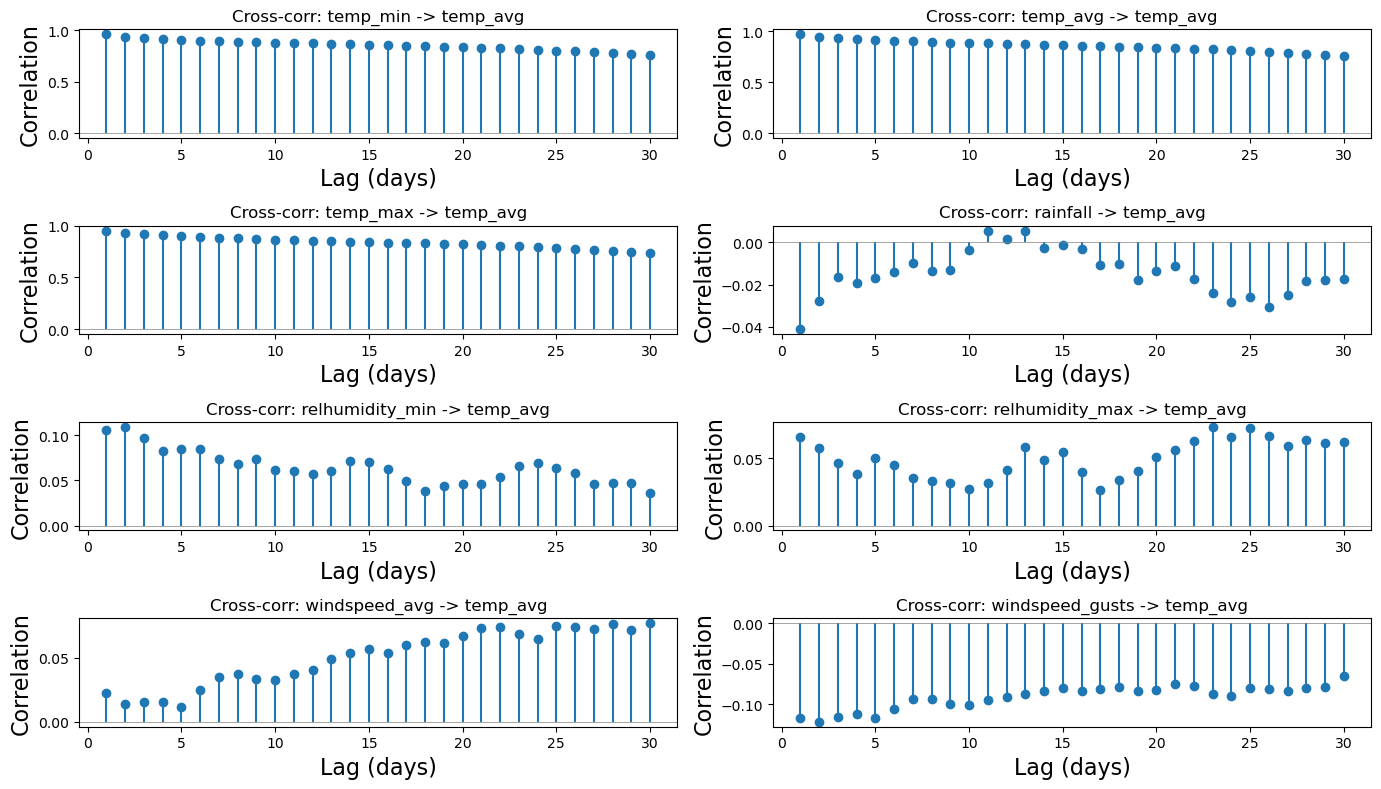

Selected features (col, lag, corr):
  temp_min        lag=  1 corr=+0.959
  temp_avg        lag=  1 corr=+0.971
  temp_max        lag=  1 corr=+0.953
  relhumidity_min lag=  2 corr=+0.110
  windspeed_gusts lag=  2 corr=-0.122
  temp_avg        lag=  2 corr=+0.000
  temp_avg        lag=  3 corr=+0.000
  temp_avg        lag=  4 corr=+0.000
  temp_avg        lag=365 corr=+0.000

Prepared data: X shape=(1003, 9), y shape=(1003,)

Multivariate model NRMSD = 0.0545
Baseline AR (lags [1, 2, 3, 4, 365]) NRMSD = 0.0509


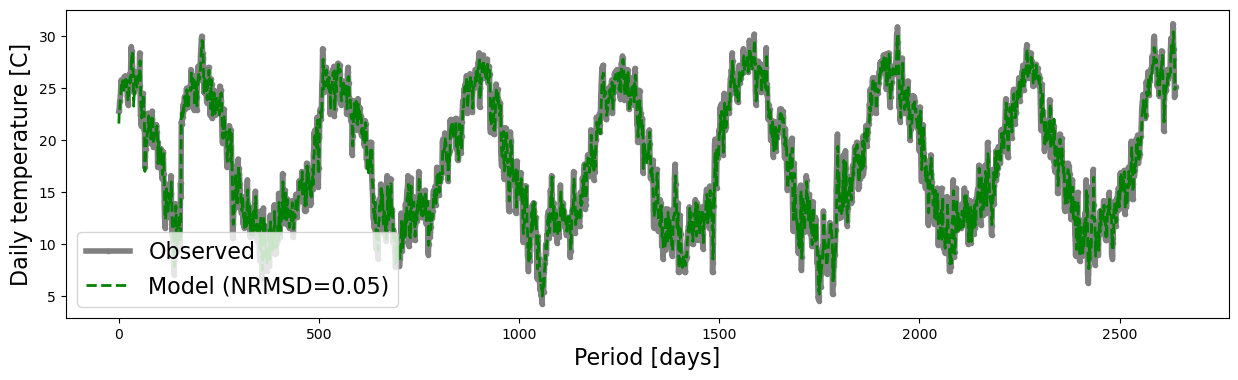

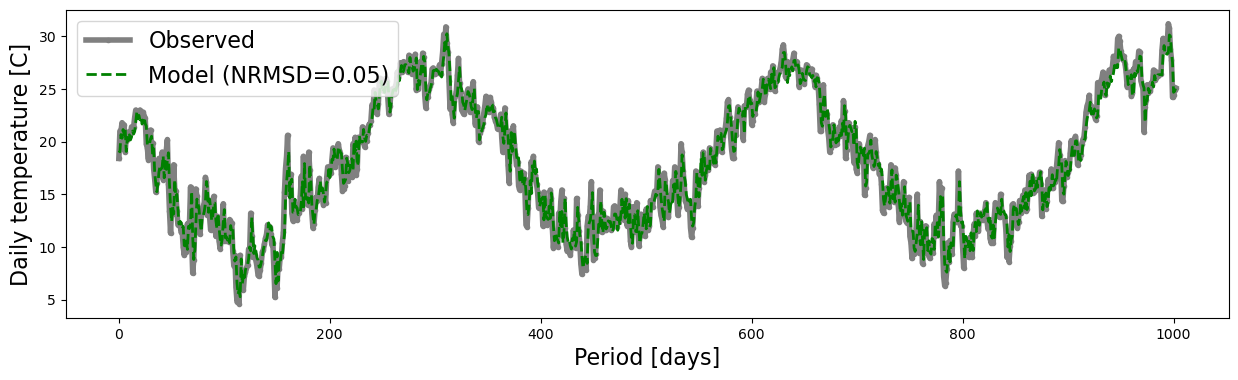

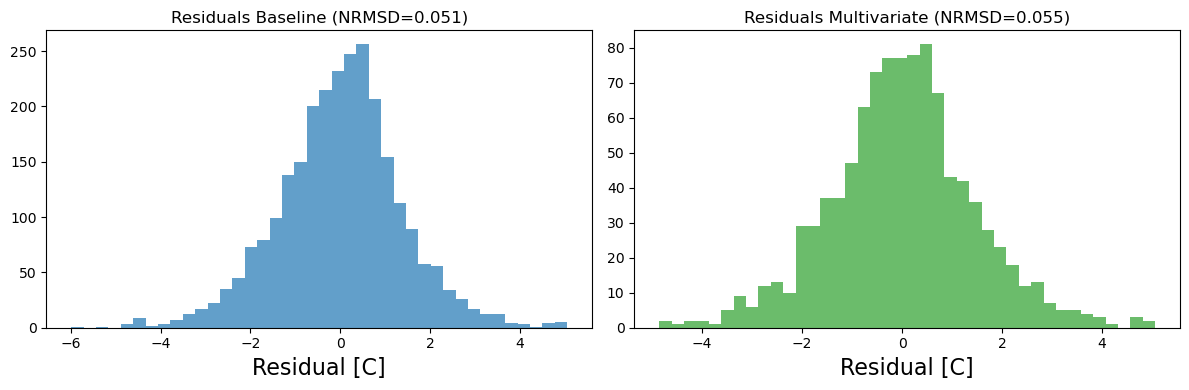


Commentary:
  No improvement: multivariate NRMSD=0.0545 vs baseline NRMSD=0.0509.
  Selected predictors were chosen by maximum absolute cross-correlation (lags up to 30 days).
  Note: evaluation uses in-sample training predictions (consistent with earlier cells). For a robust assessment use a held-out test set or cross-validation.


In [50]:


# Candidate predictors 
predictor_cols = [
    "temp_min", "temp_avg", "temp_max",
    "rainfall",
    "relhumidity_min", "relhumidity_max",
    "windspeed_avg", "windspeed_gusts"
]

# Target
target_col = "temp_avg"

# We first compute a cross-correlations function  for lags 1..max_lag for each predictor vs target
def compute_cross_correlations(target, candidate, max_lag=30):
    # THis function returns  an array of correlations for lags 1..max_lag (index 0 -> lag 1)
    corrs = []
    n = len(target)
    for lag in range(1, max_lag + 1):
        pairs_target = []
        pairs_pred = []
        for i in range(lag, n):
            t = target[i]
            p = candidate[i - lag]
            if not np.isnan(t) and not np.isnan(p):
                pairs_target.append(t)
                pairs_pred.append(p)
        if len(pairs_target) < 2:
            corrs.append(np.nan)
        else:
            corrs.append(correlation_without_nan(np.array(pairs_target), np.array(pairs_pred)))
    return np.array(corrs)

max_lag = 30  # look up to 30 days back
cross_corrs = {}
for col in predictor_cols:
    cross_corrs[col] = compute_cross_correlations(weather[target_col].values,
                                                  weather[col].values,
                                                  max_lag=max_lag)

# 2) Plot cross-correlations for each predictor (only a few plots for readability)

plt.figure(figsize=(14, 8))
n_cols = len(predictor_cols)
rows = (n_cols + 1) // 2
for idx, col in enumerate(predictor_cols, 1):
    plt.subplot(rows, 2, idx)
    lags = np.arange(1, max_lag + 1)
    plt.stem(lags, cross_corrs[col], basefmt=" ", use_line_collection=True)
    plt.title(f"Cross-corr: {col} -> {target_col}")
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.axhline(0, color='gray', linewidth=0.5)
plt.tight_layout()
plt.show()

# 3) Select lags using cross-correlation:
# For each predictor choose the lag with maximum absolute correlation (excluding NaN).
# Keep only predictors with |corr| >= threshold
threshold = 0.08
selected_features = []  # list of (col, lag, corr)
for col in predictor_cols:
    corrs = cross_corrs[col]
    if np.all(np.isnan(corrs)):
        continue
    best_idx = np.nanargmax(np.abs(corrs))  # index among 0..max_lag-1 corresponds to lag=1..max_lag
    best_lag = best_idx + 1
    best_corr = corrs[best_idx]
    if not np.isnan(best_corr) and abs(best_corr) >= threshold:
        selected_features.append((col, best_lag, best_corr))

# Also include a small set of recent autoregressive lags for temp_avg as baseline features
# (but ensure we don't duplicate features already selected)
base_temp_lags = [1, 2, 3, 4, 365]
for lag in base_temp_lags:
    if ("temp_avg", lag, None) not in [(c,l,None) for c,l,_ in selected_features]:
        selected_features.append(("temp_avg", lag, np.nan))  # corr not needed here

# Remove duplicates while preserving order (col,lag pairs)
seen = set()
final_features = []
for col, lag, corr in selected_features:
    key = (col, lag)
    if key not in seen:
        seen.add(key)
        final_features.append((col, lag, corr))
selected_features = final_features

print("Selected features (col, lag, corr):")
for col, lag, corr in selected_features:
    print(f"  {col:15s} lag={lag:3d} corr={np.nan_to_num(corr):+.3f}")

# 4) Prepare X, y for multivariate autoregression given selected (col,lag) features
def prepare_multivariate_X_y(df, target_col, features):
    # features: list of tuples (col, lag)
    n = len(df)
    max_lag = max(lag for _, lag, _ in features)
    X = []
    y = []
    arrs = {col: df[col].values for col, _, _ in features}
    target_arr = df[target_col].values
    # iterate over time indices where features are available
    for i in range(max_lag, n):
        row = []
        skip = False
        for col, lag, _ in features:
            v = df[col].values[i - lag]
            if np.isnan(v):
                skip = True
                break
            row.append(v)
        tgt = target_arr[i]
        if np.isnan(tgt) or skip:
            continue
        X.append(row)
        y.append(tgt)
    return np.array(X), np.array(y)

# Build feature list tuples (col, lag, corr) -> use only col,lag for prepare
features_for_model = [(col, lag, corr) for col, lag, corr in selected_features]
X_multi, y_multi = prepare_multivariate_X_y(weather, target_col, features_for_model)

print(f"\nPrepared data: X shape={X_multi.shape}, y shape={y_multi.shape}")

# 5) Fit linear regression and evaluate (NRMSD as used previously)
model = LinearRegression()
model.fit(X_multi, y_multi)
y_pred_multi = model.predict(X_multi)
nrmsd_multi = math.sqrt(mean_squared_error(y_multi, y_pred_multi)) / (np.max(y_multi) - np.min(y_multi))

print(f"\nMultivariate model NRMSD = {nrmsd_multi:.4f}")

# 6) Baseline: autoregressive model using only temp_avg lags [1,2,3,4,365]
# Use same prepare_multivariate_X_y pipeline
baseline_features = [( "temp_avg", lag, np.nan) for lag in base_temp_lags ]
X_base, y_base = prepare_multivariate_X_y(weather, target_col, baseline_features)
model_base = LinearRegression()
model_base.fit(X_base, y_base)
y_pred_base = model_base.predict(X_base)
nrmsd_base = math.sqrt(mean_squared_error(y_base, y_pred_base)) / (np.max(y_base) - np.min(y_base))

print(f"Baseline AR (lags {base_temp_lags}) NRMSD = {nrmsd_base:.4f}")

# 7) Plot forecasts (train predictions as in the rest of the notebook)
# Align plotting lengths: use the model-specific y vectors
plot_forecast(y_base, y_pred_base, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd_base)
plot_forecast(y_multi, y_pred_multi, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd_multi)

# 8) Residual diagnostics
res_base = y_base - y_pred_base
res_multi = y_multi - y_pred_multi

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(res_base, bins=40, color='tab:blue', alpha=0.7)
plt.title(f"Residuals Baseline (NRMSD={nrmsd_base:.3f})")
plt.xlabel("Residual [C]")
plt.subplot(1,2,2)
plt.hist(res_multi, bins=40, color='tab:green', alpha=0.7)
plt.title(f"Residuals Multivariate (NRMSD={nrmsd_multi:.3f})")
plt.xlabel("Residual [C]")
plt.tight_layout()
plt.show()

# 9) Print brief commentary
print("\nCommentary:")
if nrmsd_multi < nrmsd_base:
    print(f"  The multivariate model (NRMSD={nrmsd_multi:.4f}) improved over the baseline AR model (NRMSD={nrmsd_base:.4f}).")
else:
    print(f"  No improvement: multivariate NRMSD={nrmsd_multi:.4f} vs baseline NRMSD={nrmsd_base:.4f}.")
print("  Selected predictors were chosen by maximum absolute cross-correlation (lags up to 30 days).")
print("  Note: evaluation uses in-sample training predictions (consistent with earlier cells). For a robust assessment use a held-out test set or cross-validation.")

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>